In [1]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata


import src.codes.reductor.rom_class as rom_class
from src.codes.algorithms.ecsw import ecsw_red
from importlib import reload


### class for data (geometry, material property, mesh)

In [3]:
nref= [10,2]
L = [20,20]
mat_layout = np.zeros((5,2),dtype=int)
src_layout = np.zeros((5,2),dtype=int)

In [4]:
fdict = {}

cond_list = []
cond_list.append( lambda T,mu: mu*T + 100. + 0.*T )
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append( lambda T,mu: mu + 0. + 0.*T )
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 100.0 + 0.0*T )
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [5]:
bc = {}
bc['x_min']={'type':'dirichlet','value':10.0}
bc['x_max']={'type':'dirichlet','value':10.0}
bc['y_min']={'type':'dirichlet','value':10.0}
bc['y_max']={'type':'refl','value':np.nan}

### Simulate FOS

In [6]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []
# 


 Snap 0


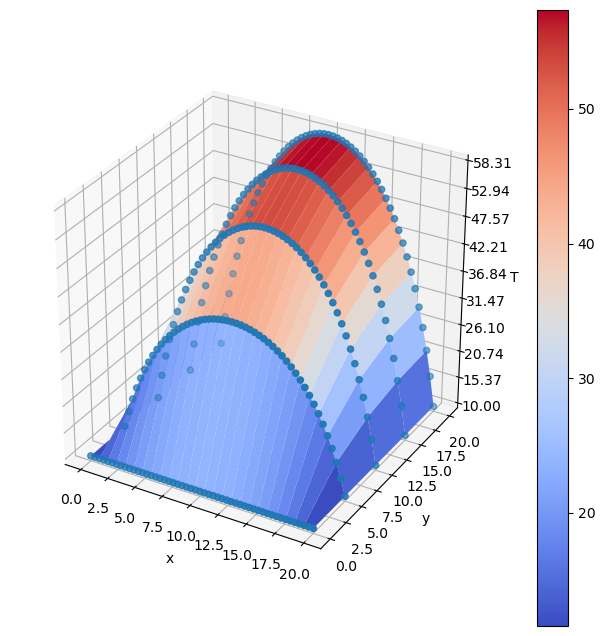


 Snap 1


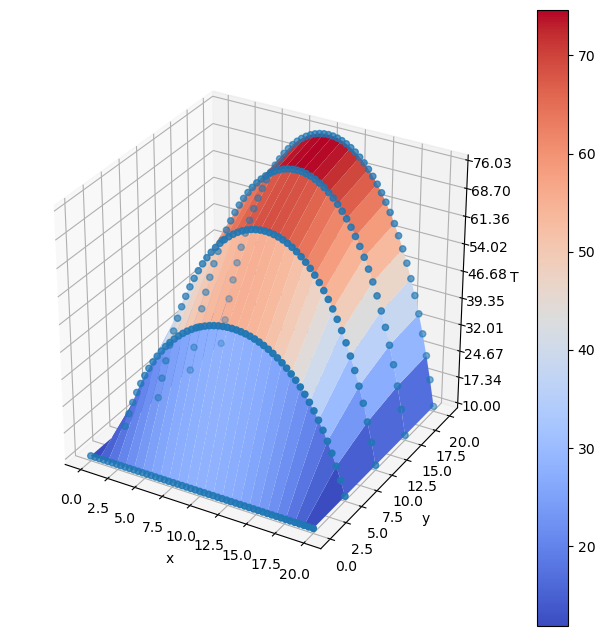


 Snap 2


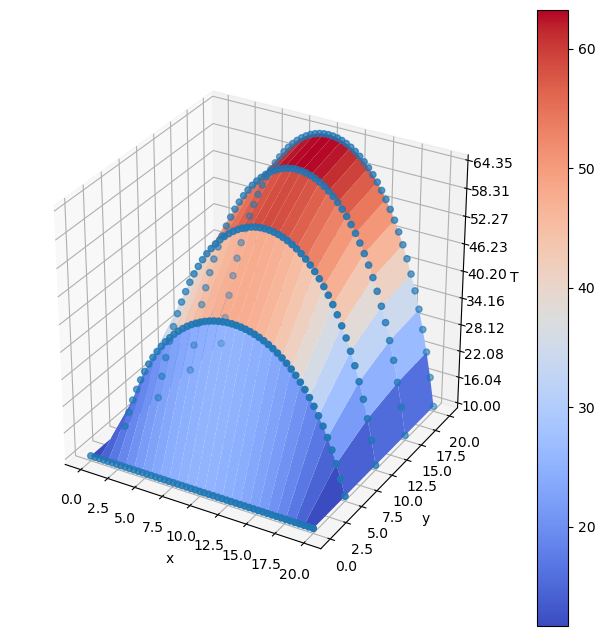


 Snap 3

 Snap 4

 Snap 5

 Snap 6

 Snap 7

 Snap 8

 Snap 9

 Snap 10

 Snap 11

 Snap 12

 Snap 13

 Snap 14


In [7]:
for i in range(N_snap):
    print(f"\n Snap {i}")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=2)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 2.0
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)

    if i<3:
        plot2D(d.xi[0], d.xi[1], NL_solution_p)

In [8]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 255)

### ECSW Hyper-reduction


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

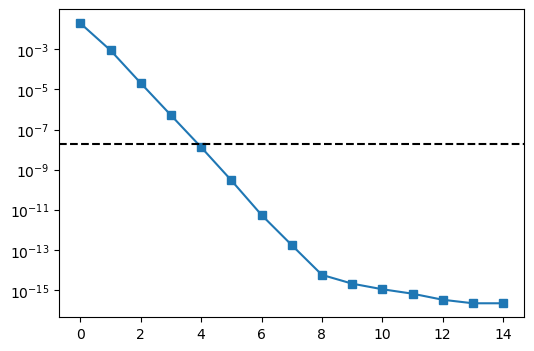

In [9]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=2e-8)
V_sel = U[:, :n_sel]

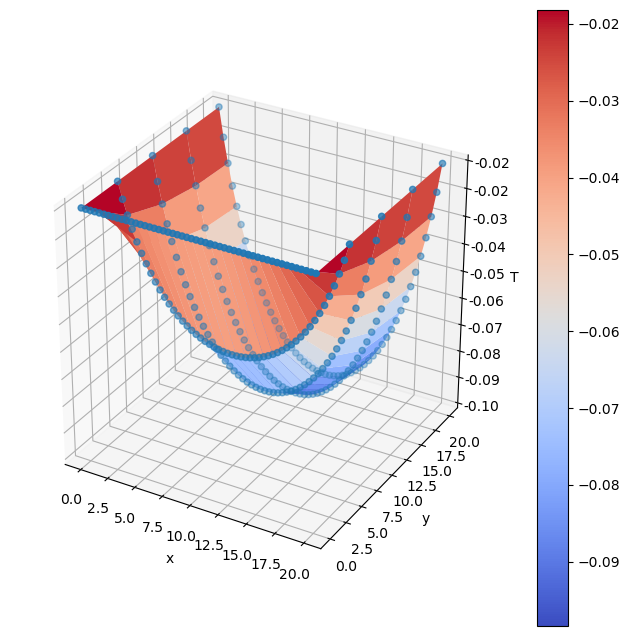

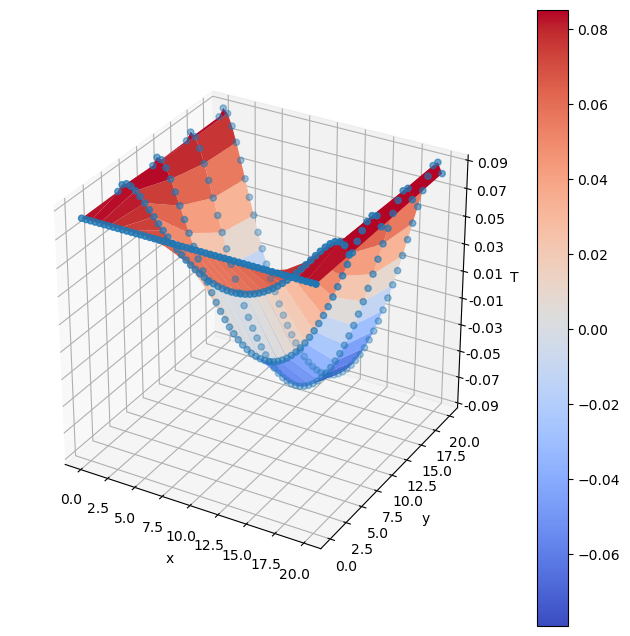

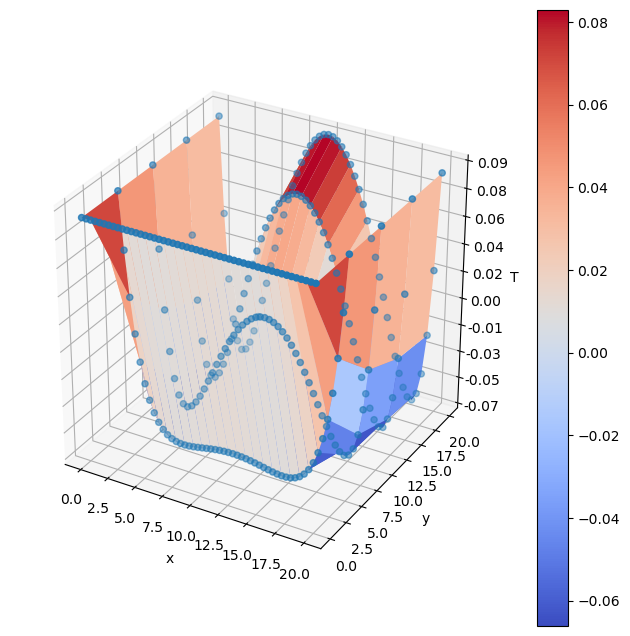

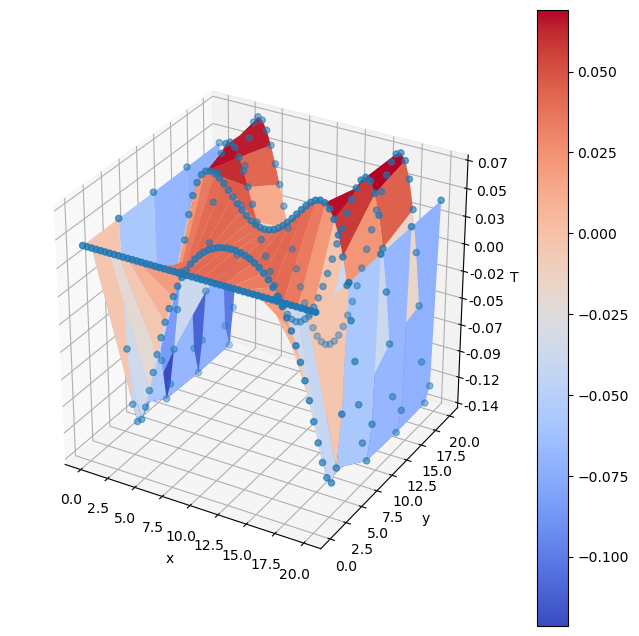

In [10]:
V_sel = U[:, :n_sel]

for i in range(n_sel):
    plot2D(d.xi[0], d.xi[1], V_sel[:,i])
    
plt.show()


#### Step 2: ECSW

In [11]:
tic_h_setup_b = time.time()
tol = 1e-8
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap, mask,NL_solutions,tol=tol)
toc_h_setup_b = time.time()

d:\D\ONEDRIVE\OneDrive - Texas A&M University\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\Hyperreduction_tamids\pyHyperRom\src\codes\algorithms\nnls_scipy.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=3.3676e-17): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
d:\D\ONEDRIVE\OneDrive - Texas A&M University\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\Hyperreduction_tamids\pyHyperRom\src\codes\algorithms\nnls_scipy.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=1.63494e-17): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],


In [12]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 0.00010012808118765914


In [13]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

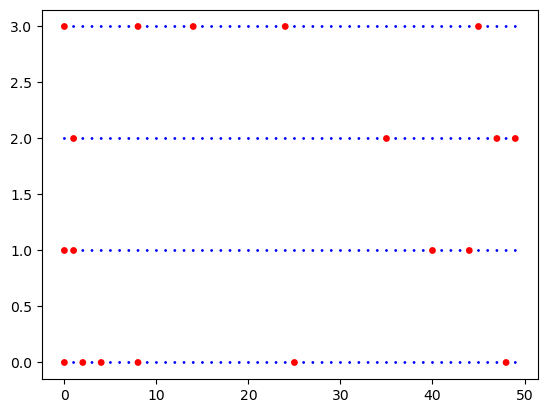

In [14]:
plot2D(np.arange(d.ncells[0]),np.arange(d.ncells[1]), xi, scattr=True, clr=colors, sz=sizes)

In [15]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 9.5%



### ROM Simulation

In [16]:
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [17]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, nref, L, param_rom, pb_dim=2)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_ecsw(d_test, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [18]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 2.
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [19]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [20]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
toc_rom_woh = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [21]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

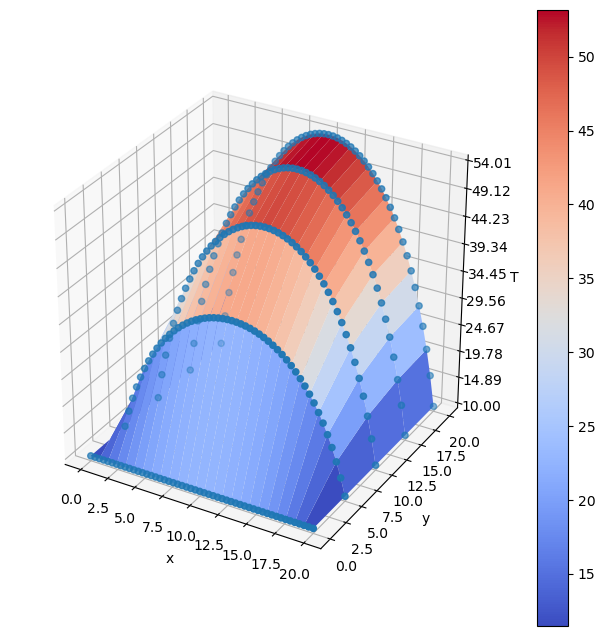

RMS_error is 3.805953098273504e-05 %


In [22]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot2D(d_test.xi[0], d_test.xi[1], sol_red)

print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

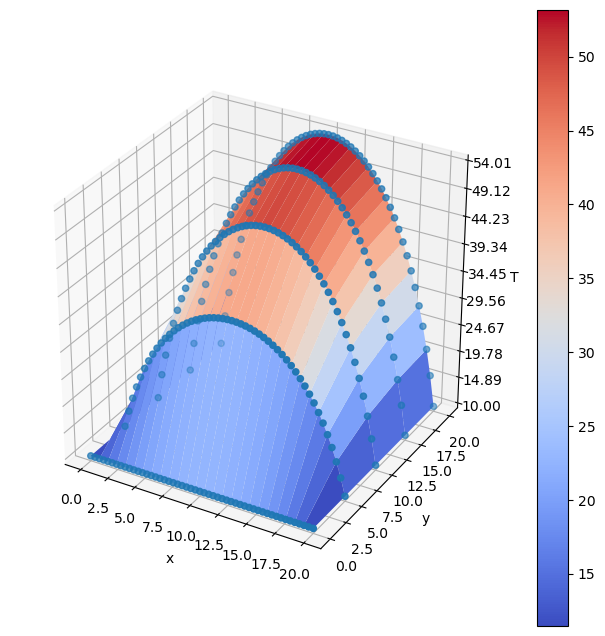



ROM Error without hyperreduction is 3.760162341254674e-05 %


In [23]:
plot2D(d_test.xi[0], d_test.xi[1], NL_solution_p_fos_test)

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")


#### Speedups

In [24]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [25]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:0.6580953507363656
speedup with hyperreduction:6.728266034930553
